# Python Practice Lecture 21 MATH 342W Queens College
# - Probability Estimation for Classification
Author: Amir ElTabakh
Date: April 21, 2022

Agenda:
* Joins
* Using Probability Estimation to do Classification
* Asymmetric Cost Classifiers

## Joins

Another one of the core data munging skills is joining data frames together. In the real world, databases consist of multiple dataframes called "tables" and design matrices are built by gathering data from among many tables. To illustrate this, we load two datasets from the package `nycflights13`, one dataset about weather and one about airports:

In [1]:
# install nycflights13
#!pip install nycflights13

In [2]:
# importing weather df
from nycflights13 import weather

# snapshot
weather

,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,1,39.02,26.06,59.37,270.0,10.35702,NaN,0.0,1012.0,10.0,2013-01-01T06:00:00Z
1,EWR,2013,1,1,2,39.02,26.96,61.63,250.0,8.05546,NaN,0.0,1012.3,10.0,2013-01-01T07:00:00Z
2,EWR,2013,1,1,3,39.02,28.04,64.43,240.0,11.50780,NaN,0.0,1012.5,10.0,2013-01-01T08:00:00Z
3,EWR,2013,1,1,4,39.92,28.04,62.21,250.0,12.65858,NaN,0.0,1012.2,10.0,2013-01-01T09:00:00Z
4,EWR,2013,1,1,5,39.02,28.04,64.43,260.0,12.65858,NaN,0.0,1011.9,10.0,2013-01-01T10:00:00Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26110,LGA,2013,12,30,14,35.96,19.94,51.78,340.0,13.80936,21.86482,0.0,1017.1,10.0,2013-12-30T19:00:00Z
26111,LGA,2013,12,30,15,33.98,17.06,49.51,330.0,17.26170,21.86482,0.0,1018.8,10.0,2013-12-30T20:00:00Z
26112,LGA,2013,12,30,16,32.00,15.08,49.19,340.0,14.96014,23.01560,0.0,1019.5,10.0,2013-12-30T21:00:00Z
26113,LGA,2013,12,30,17,30.92,12.92,46.74,320.0,17.26170,NaN,0.0,1019.9,10.0,2013-12-30T22:00:00Z


In [3]:
# importing weather df
from nycflights13 import airports

# snapshot
airports

,faa,name,lat,lon,alt,tz,dst,tzone
0,04G,Lansdowne Airport,41.130472,-80.619583,1044,-5,A,America/New_York
1,06A,Moton Field Municipal Airport,32.460572,-85.680028,264,-6,A,America/Chicago
2,06C,Schaumburg Regional,41.989341,-88.101243,801,-6,A,America/Chicago
3,06N,Randall Airport,41.431912,-74.391561,523,-5,A,America/New_York
4,09J,Jekyll Island Airport,31.074472,-81.427778,11,-5,A,America/New_York
...,...,...,...,...,...,...,...,...
1453,ZUN,Black Rock,35.083228,-108.791778,6454,-7,A,America/Denver
1454,ZVE,New Haven Rail Station,41.298669,-72.925992,7,-5,A,America/New_York
1455,ZWI,Wilmington Amtrak Station,39.736667,-75.551667,0,-5,A,America/New_York
1456,ZWU,Washington Union Station,38.897460,-77.006430,76,-5,A,America/New_York


Note how the weather and airports datasets contain a common feature: name of airport. It is called `FAA` in airports and `origin` in weather.

First we rename the column in weather to match the column in airports:

In [4]:
# change column name
weather = weather.rename(columns = {weather.columns[0]: "faa"})
weather.head()

,faa,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2013,1,1,1,39.02,26.06,59.37,270.0,10.35702,NaN,0.0,1012.0,10.0,2013-01-01T06:00:00Z
1,EWR,2013,1,1,2,39.02,26.96,61.63,250.0,8.05546,NaN,0.0,1012.3,10.0,2013-01-01T07:00:00Z
2,EWR,2013,1,1,3,39.02,28.04,64.43,240.0,11.50780,NaN,0.0,1012.5,10.0,2013-01-01T08:00:00Z
3,EWR,2013,1,1,4,39.92,28.04,62.21,250.0,12.65858,NaN,0.0,1012.2,10.0,2013-01-01T09:00:00Z
4,EWR,2013,1,1,5,39.02,28.04,64.43,260.0,12.65858,NaN,0.0,1011.9,10.0,2013-01-01T10:00:00Z


We also pare down the datasets so we can see the joins more clearly:

In [5]:
# subset of weather
weather = weather[["faa", "time_hour", "temp", "humid", "wind_speed", "pressure", "wind_gust"]]
weather.head()

,faa,time_hour,temp,humid,wind_speed,pressure,wind_gust
0,EWR,2013-01-01T06:00:00Z,39.02,59.37,10.35702,1012.0,NaN
1,EWR,2013-01-01T07:00:00Z,39.02,61.63,8.05546,1012.3,NaN
2,EWR,2013-01-01T08:00:00Z,39.02,64.43,11.50780,1012.5,NaN
3,EWR,2013-01-01T09:00:00Z,39.92,62.21,12.65858,1012.2,NaN
4,EWR,2013-01-01T10:00:00Z,39.02,64.43,12.65858,1011.9,NaN


In [6]:
# subset of airports
airports = airports[["faa", "lat", "lon"]]
airports.head()

,faa,lat,lon
0,04G,41.130472,-80.619583
1,06A,32.460572,-85.680028
2,06C,41.989341,-88.101243
3,06N,41.431912,-74.391561
4,09J,31.074472,-81.427778


Some features just aren't measured that often e.g. `wind_gust`.

Let's do some joins. First "left". This is likely the most common because it's usually how we conceptualize what we're doing in our heads.

We will be using [`pandas.merge`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html), press the hyperlink to see the documentation. Of course you can always use the `help()` function.

There are a number of different ways to join two dataframes:
Type of merge to be performed.

* left: use only keys from left frame, similar to a SQL left outer join; preserve key order.

* right: use only keys from right frame, similar to a SQL right outer join; preserve key order.

* outer: use union of keys from both frames, similar to a SQL full outer join; sort keys lexicographically.

* inner: use intersection of keys from both frames, similar to a SQL inner join; preserve the order of the left keys.

* cross: creates the cartesian product from both frames, preserves the order of the left keys.

In [7]:
# importing dependencies
import pandas as pd

In [8]:
# Left join
airports_and_weather_left = airports.merge(weather, left_on = 'faa', right_on = 'faa', how = 'left')
airports_and_weather_left

,faa,lat,lon,time_hour,temp,humid,wind_speed,pressure,wind_gust
0,04G,41.130472,-80.619583,NaN,NaN,NaN,NaN,NaN,NaN
1,06A,32.460572,-85.680028,NaN,NaN,NaN,NaN,NaN,NaN
2,06C,41.989341,-88.101243,NaN,NaN,NaN,NaN,NaN,NaN
3,06N,41.431912,-74.391561,NaN,NaN,NaN,NaN,NaN,NaN
4,09J,31.074472,-81.427778,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
27565,ZUN,35.083228,-108.791778,NaN,NaN,NaN,NaN,NaN,NaN
27566,ZVE,41.298669,-72.925992,NaN,NaN,NaN,NaN,NaN,NaN
27567,ZWI,39.736667,-75.551667,NaN,NaN,NaN,NaN,NaN,NaN
27568,ZWU,38.897460,-77.006430,NaN,NaN,NaN,NaN,NaN,NaN


Now "right".

In [9]:
# Right join
airports_and_weather_right = airports.merge(weather, left_on = 'faa', right_on = 'faa', how = 'right')
airports_and_weather_right

,faa,lat,lon,time_hour,temp,humid,wind_speed,pressure,wind_gust
0,EWR,40.692500,-74.168667,2013-01-01T06:00:00Z,39.02,59.37,10.35702,1012.0,NaN
1,EWR,40.692500,-74.168667,2013-01-01T07:00:00Z,39.02,61.63,8.05546,1012.3,NaN
2,EWR,40.692500,-74.168667,2013-01-01T08:00:00Z,39.02,64.43,11.50780,1012.5,NaN
3,EWR,40.692500,-74.168667,2013-01-01T09:00:00Z,39.92,62.21,12.65858,1012.2,NaN
4,EWR,40.692500,-74.168667,2013-01-01T10:00:00Z,39.02,64.43,12.65858,1011.9,NaN
...,...,...,...,...,...,...,...,...,...
26110,LGA,40.777245,-73.872608,2013-12-30T19:00:00Z,35.96,51.78,13.80936,1017.1,21.86482
26111,LGA,40.777245,-73.872608,2013-12-30T20:00:00Z,33.98,49.51,17.26170,1018.8,21.86482
26112,LGA,40.777245,-73.872608,2013-12-30T21:00:00Z,32.00,49.19,14.96014,1019.5,23.01560
26113,LGA,40.777245,-73.872608,2013-12-30T22:00:00Z,30.92,46.74,17.26170,1019.9,NaN


And now a full outer joine, keeping all the rows.

In [10]:
# Outer join
airports_and_weather_outer = airports.merge(weather, left_on = 'faa', right_on = 'faa', how = 'outer')
airports_and_weather_outer

,faa,lat,lon,time_hour,temp,humid,wind_speed,pressure,wind_gust
0,04G,41.130472,-80.619583,NaN,NaN,NaN,NaN,NaN,NaN
1,06A,32.460572,-85.680028,NaN,NaN,NaN,NaN,NaN,NaN
2,06C,41.989341,-88.101243,NaN,NaN,NaN,NaN,NaN,NaN
3,06N,41.431912,-74.391561,NaN,NaN,NaN,NaN,NaN,NaN
4,09J,31.074472,-81.427778,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
27565,ZUN,35.083228,-108.791778,NaN,NaN,NaN,NaN,NaN,NaN
27566,ZVE,41.298669,-72.925992,NaN,NaN,NaN,NaN,NaN,NaN
27567,ZWI,39.736667,-75.551667,NaN,NaN,NaN,NaN,NaN,NaN
27568,ZWU,38.897460,-77.006430,NaN,NaN,NaN,NaN,NaN,NaN


Lastly we will use an inner join. An inner join uses the intersection of the keys from both dataframes.

In [11]:
# Inner join
airports_and_weather_inner = airports.merge(weather, left_on = 'faa', right_on = 'faa', how = 'inner')
airports_and_weather_inner

,faa,lat,lon,time_hour,temp,humid,wind_speed,pressure,wind_gust
0,EWR,40.692500,-74.168667,2013-01-01T06:00:00Z,39.02,59.37,10.35702,1012.0,NaN
1,EWR,40.692500,-74.168667,2013-01-01T07:00:00Z,39.02,61.63,8.05546,1012.3,NaN
2,EWR,40.692500,-74.168667,2013-01-01T08:00:00Z,39.02,64.43,11.50780,1012.5,NaN
3,EWR,40.692500,-74.168667,2013-01-01T09:00:00Z,39.92,62.21,12.65858,1012.2,NaN
4,EWR,40.692500,-74.168667,2013-01-01T10:00:00Z,39.02,64.43,12.65858,1011.9,NaN
...,...,...,...,...,...,...,...,...,...
26110,LGA,40.777245,-73.872608,2013-12-30T19:00:00Z,35.96,51.78,13.80936,1017.1,21.86482
26111,LGA,40.777245,-73.872608,2013-12-30T20:00:00Z,33.98,49.51,17.26170,1018.8,21.86482
26112,LGA,40.777245,-73.872608,2013-12-30T21:00:00Z,32.00,49.19,14.96014,1019.5,23.01560
26113,LGA,40.777245,-73.872608,2013-12-30T22:00:00Z,30.92,46.74,17.26170,1019.9,NaN


There is also `semi_join` and `anti_join` that do the opposite of joining. In my experience, these use cases are limited.

## Using Probability Estimation to do Classification

First repeat quickly (a) load the adult data (b) do a training / test split and (c) build the logisitc model.


In [12]:
# importing dependencies
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd

# Data viz
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("colorblind")) # setting color palette
sns.set(rc={"figure.figsize":(10, 6)}) #width=10, #height=6

In [13]:
# URL for adult Data
url = "https://raw.githubusercontent.com/sfnxboy/342-2022-Python-Practice-lectures/main/Datasets/ucidata_adult.csv"
adult = pd.read_csv(url, error_bad_lines=False)

# snapshot of dataframe
adult

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


We'll drop all rows that contain missing values, `NaN`.

In [14]:
# dropping rows that contain a missing value
adult = adult.dropna()
adult

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


Now we dummify the categorical variables.

In [15]:
# dummifying categorical variables
adult = pd.get_dummies(adult)
adult.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia,income_<=50K,income_>50K
0,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
3,28,338409,13,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,37,284582,14,0,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0


Now we are ready to create our logistic regression model. In lecture 17, the Logistic Regression lecture, I used the `statsmodels.api` library. Here we'll use [sci-kit learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Note that income here is a binary variable, not continuous.


In [16]:
# defining X and y
X = adult.iloc[:, :-1]
y = adult.iloc[:, -1]

# adding 1 vector to X
X.insert(0, "one_vec", 1)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 1994)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(22620, 106)
(7541, 106)
(22620,)
(7541,)


In [17]:
# Fitting logistic regression model
model = LogisticRegression(random_state=0, solver = 'saga').fit(X_train, y_train)

y_hats_train = model.predict(X_train)
y_hats_test = model.predict(X_test)

# if you want to get the probabilities you can do the following
p_hats_train = model.predict_proba(X_train)[:, 1]
p_hats_test = model.predict_proba(X_test)[:, 1]

# The phat results are tricky to interpret, refer to documentation

E:\Users\amira\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


`model.predict` sets the following rule by default, if the probability estimate is greater than or equal to 50%, let's classify the observation as positive, otherwise 0. `model.predict_proba` returns the calculated probability by the model.

Let's take a look at all the in-sample probability estimates:

<AxesSubplot:ylabel='Count'>

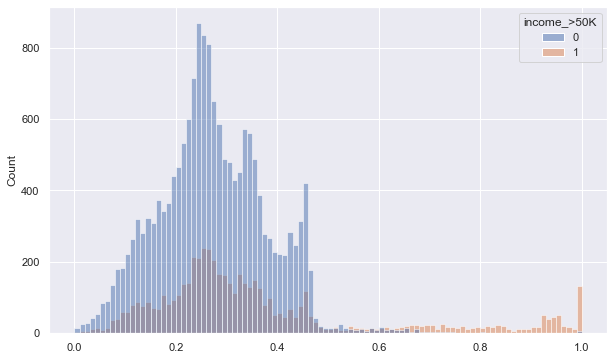

In [18]:
# lets plot how the model did in sample
sns.histplot(x = p_hats_train, hue = y_train, bins = 100)

And the oos probability estimates.

<AxesSubplot:ylabel='Count'>

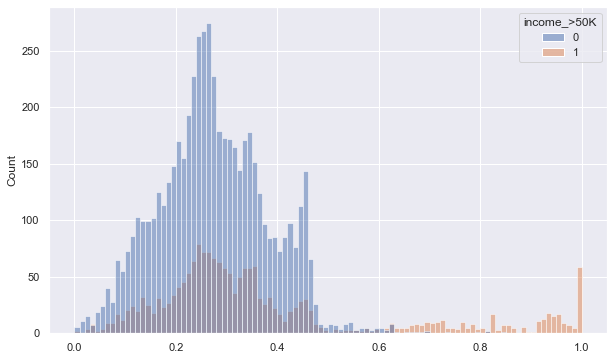

In [19]:
# lets plot how the model did oos
sns.histplot(x = p_hats_test, hue = y_test, bins = 100)

To create a confusion matrix for a logistic regression model in Python, we can use the confusion_matrix() function from the sklearn package [metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html):

[[16742   272]
 [ 4557  1049]]


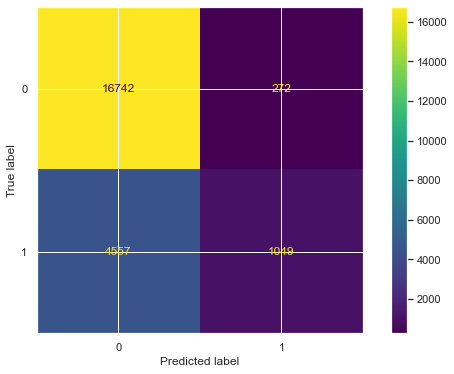

In [20]:
# in sample confusion matrix
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay


c_matrix_in_sample = metrics.confusion_matrix(y_train, y_hats_train)
print(c_matrix_in_sample)

# plotting it
ConfusionMatrixDisplay.from_predictions(y_train, y_hats_train)

And out of sample.

[[5553   86]
 [1531  371]]


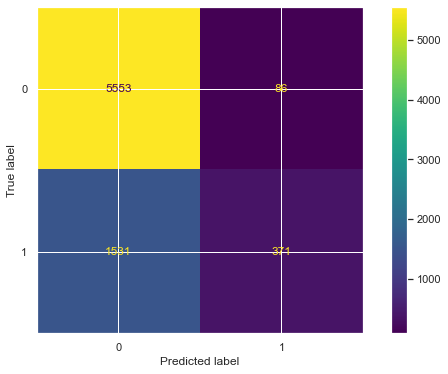

In [21]:
# in sample confusion matrix
from sklearn import metrics
c_matrix_oos = metrics.confusion_matrix(y_test, y_hats_test)

print(c_matrix_oos)

# confusion plot
ConfusionMatrixDisplay.from_predictions(y_test, y_hats_test)

We can quickly retrieve the true negative, false positive, false negative and true positive rates. We'll do so for the out of sample metrics.

In [22]:
tn, fp, fn, tp = c_matrix_oos.ravel()
print(tn, fp, fn, tp)

5553 86 1531 371


Let's calculate the estimates of the future performance for each class.

In [23]:
num_pred_pos = np.sum(c_matrix_oos[:, 1])
num_pred_neg = np.sum(c_matrix_oos[:, 0])
num_true_pos = np.sum(c_matrix_oos[1, :])
num_true_neg = np.sum(c_matrix_oos[0, :])

print(f"Predicted Positives: {num_pred_pos}")
print(f"Predicted Negatives: {num_pred_neg}")
print(f"Actual Positives: {num_true_pos}")
print(f"Actual Negatives: {num_true_neg}")

Predicted Positives: 457
Predicted Negatives: 7084
Actual Positives: 1902
Actual Negatives: 5639


In [24]:
# precision
precision = tp / num_pred_pos
print(round(precision, 5))

0.81182


In [25]:
# recall
recall = tp / num_true_pos
print(round(recall, 5))

0.19506


In [26]:
# false discovery rate
false_discovery_rate = 1 - precision
print(round(false_discovery_rate, 5))

0.18818


In [27]:
# false ommision rate
false_ommision_rate = fn / num_pred_neg
print(round(false_ommision_rate, 5))

0.21612


This whole classifier hinged on the decision of 50%, what if we change it?

Note that sklearn has a bunch of functions for classification metrics. We calculate the metrics manually here, but in practice you should be aware of the functions that exist, they can streamline your process, prevent errors, and makes your code more readable. Read the documentation [here](https://scikit-learn.org/stable/modules/classes.html#classification-metrics).

## Asymmetric Cost Classifiers

Let's establish a *new* rule: if the probability estimate is greater than or equal to 90%, let's classify the observation as positive, otherwise 0.

[[5639    0]
 [1747  155]]


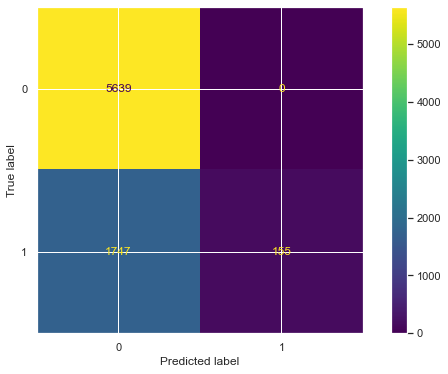

In [28]:
# defining y hats test
y_hats_test = [1 if p_hats_test[i] >= 0.9 else 0 for i in range(len(p_hats_test))]

c_matrix_oos = metrics.confusion_matrix(y_test, y_hats_test)
print(c_matrix_oos)

# confusion plot
ConfusionMatrixDisplay.from_predictions(y_test, y_hats_test)

In [29]:
tn, fp, fn, tp = c_matrix_oos.ravel()

print(f"True Postives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

num_pred_pos = np.sum(c_matrix_oos[:, 1])
num_pred_neg = np.sum(c_matrix_oos[:, 0])
num_true_pos = np.sum(c_matrix_oos[1, :])
num_true_neg = np.sum(c_matrix_oos[0, :])

print(f"Predicted Positives: {num_pred_pos}")
print(f"Predicted Negatives: {num_pred_neg}")
print(f"Actual Positives: {num_true_pos}")
print(f"Actual Negatives: {num_true_neg}")

# precision
precision = tp / num_pred_pos
print(f"Precision: {round(precision, 5)}")

# recall
recall = tp / num_true_pos
print(f"Recall: {round(recall, 5)}")

# false discovery rate
false_discovery_rate = 1 - precision
print(f"FDR: {round(false_discovery_rate, 5)}")

# false ommision rate
false_ommision_rate = fn / num_pred_neg
print(f"FOR: {round(false_ommision_rate, 5)}")

True Postives: 155
True Negatives: 5639
False Positives: 0
False Negatives: 1747
Predicted Positives: 155
Predicted Negatives: 7386
Actual Positives: 1902
Actual Negatives: 5639
Precision: 1.0
Recall: 0.08149
FDR: 0.0
FOR: 0.23653


We don't make many false discoveries but we make a lot of false omissions! It's a tradeoff...